In [1]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import numpy as np
import re
import plotly as pl 
import matplotlib.pyplot as plt
# Import db related librarys
import psycopg2
import sys
import os
import sqlalchemy
import json
import csv
from getpass import getpass


In [2]:
# Configure connection parameters to AWS RDS
def connect_to_db():
    
    connection = None
    #enter_password = getpass('Enter database password')
    
    try:
        print('Connecting to the PostgreSQL database...')
        connection = psycopg2.connect(
            host = "database-chocolate.cafzzay3t2tr.us-east-2.rds.amazonaws.com",
            port = 5432,
            user = 'postgres',
            password = getpass('Enter database password'),
            database = 'postgres'
            )
        print('Connection successful')
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    return connection


In [3]:
# Call the connect_to_db to connect to database
connection = connect_to_db()

Connecting to the PostgreSQL database...
Enter database password········
Connection successful


In [4]:
# Create cursor to perform database operations
cursor = connection.cursor()

# If curser object = 0, then connection was successfully established
cursor

<cursor object at 0x0000020090430048; closed: 0>

In [5]:
# Query the location_table from AWS database and store in dataframe - verify there is data in the table.
sql = """
SELECT * FROM location_table
"""

location_table_from_db = pd.read_sql(sql, con=connection)

In [6]:
# Display the location_table queried from database
location_table_from_db

,country_code,latitude,longitude,broad_bean_origin_country
0,AD,42.546245,1.601554,Andorra
1,AE,23.424076,53.847818,United Arab Emirates
2,AF,33.939110,67.709953,Afghanistan
3,AG,17.060816,-61.796428,Antigua and Barbuda
4,AI,18.220554,-63.068615,Anguilla
...,...,...,...,...
242,ZM,-13.133897,27.849332,Zambia
243,ZW,-19.015438,29.154857,Zimbabwe
244,HI,19.898682,-155.665857,Hawaii
245,ZZ,0.000000,0.000000,Unknown


In [7]:
# Query the clean_flavours_table from AWS database and store in dataframe.
sql = """
SELECT * FROM clean_flavors_table
"""

clean_flavors_from_db = pd.read_sql(sql, con=connection)

In [8]:
clean_flavors_from_db

,company,bean_origin_or_bar_name,REF,review_date,cocoa_percent,company_location,rating,bean_type,broad_bean_origin_country,ingredients,most_memorable_characteristics,continent
0,A. Morin,Agua Grande,1876,2016,63.0,France,3.75,missing,Sao Tome & Principe,"4- B,S,C,L","sweet, chocolatey, vegetal",Africa
1,A. Morin,Kpime,1676,2015,70.0,France,2.75,missing,Togo,"4- B,S,C,L","burnt wood, earthy, choco",Africa
2,A. Morin,Atsane,1676,2015,70.0,France,3.00,missing,Togo,"4- B,S,C,L","roasty, acidic, nutty",Africa
3,A. Morin,Akata,1680,2015,70.0,France,3.50,missing,Togo,"4- B,S,C,L","mild profile, chocolaty, spice",Africa
4,A. Morin,Quilla,1704,2015,70.0,France,3.50,missing,Peru,"4- B,S,C,L","grainy texture, cocoa, sweet",South America
...,...,...,...,...,...,...,...,...,...,...,...,...
1955,Zotter,Peru,647,2011,70.0,Austria,3.75,missing,Peru,"4- B,Sw,C,Sa","creamy, fatty, mild nutty",South America
1956,Zotter,Congo,749,2011,65.0,Austria,3.00,Forastero,Republic of Congo,"4- B,Sw,C,Sa","dairy, salt, caramel",Africa
1957,Zotter,Kerala State,749,2011,65.0,Austria,3.50,Forastero,India,"4- B,Sw,C,Sa","creamy, masculine, earthy",Asia
1958,Zotter,Kerala State,781,2011,62.0,Austria,3.25,missing,India,"4- B,Sw,C,Sa","oily, subdued, caramel, salt",Asia


In [9]:
# Join the 2 tables together on broad_bean_origin_country, select the columns you want to view in df

sql = """ SELECT clean_flavors_table .*, location_table.country_code,location_table.longitude, location_table.latitude
FROM clean_flavors_table
LEFT JOIN location_table
ON clean_flavors_table.broad_bean_origin_country = location_table.broad_bean_origin_country;
"""

# Store the joined tables in dataframe
df_chocolate = pd.read_sql(sql, con=connection)

# View the new dataframe combined from two sql tables
df_chocolate.head(10)

,company,bean_origin_or_bar_name,REF,review_date,cocoa_percent,company_location,rating,bean_type,broad_bean_origin_country,ingredients,most_memorable_characteristics,continent,country_code,longitude,latitude
0,A. Morin,Agua Grande,1876,2016,63.0,France,3.75,missing,Sao Tome & Principe,"4- B,S,C,L","sweet, chocolatey, vegetal",Africa,ST,6.613081,0.186360
1,A. Morin,Kpime,1676,2015,70.0,France,2.75,missing,Togo,"4- B,S,C,L","burnt wood, earthy, choco",Africa,TG,0.824782,8.619543
2,A. Morin,Atsane,1676,2015,70.0,France,3.00,missing,Togo,"4- B,S,C,L","roasty, acidic, nutty",Africa,TG,0.824782,8.619543
3,A. Morin,Akata,1680,2015,70.0,France,3.50,missing,Togo,"4- B,S,C,L","mild profile, chocolaty, spice",Africa,TG,0.824782,8.619543
4,A. Morin,Quilla,1704,2015,70.0,France,3.50,missing,Peru,"4- B,S,C,L","grainy texture, cocoa, sweet",South America,PE,-75.015152,-9.189967
5,A. Morin,Carenero,1315,2014,70.0,France,2.75,Criollo,Venezuela,Unknown,missing,South America,VE,-66.589730,6.423750
6,A. Morin,Cuba,1315,2014,70.0,France,3.50,missing,Cuba,"4- B,S,C,L","sliglty dry, papaya",Caribbean,CU,-77.781167,21.521757
7,A. Morin,Sur del Lago,1315,2014,70.0,France,3.50,Criollo,Venezuela,Unknown,missing,South America,VE,-66.589730,6.423750
8,A. Morin,Puerto Cabello,1319,2014,70.0,France,3.75,Criollo,Venezuela,Unknown,missing,South America,VE,-66.589730,6.423750
9,A. Morin,Pablino,1319,2014,70.0,France,4.00,missing,Peru,"4- B,S,C,L","delicate, hazelnut, brownie",South America,PE,-75.015152,-9.189967


In [10]:
# Close connection to RDS
cursor.close()
# Check that connection is closed where object returned = -1
cursor

<cursor object at 0x0000020090430048; closed: -1>

# Machine Learning 



In [11]:
def bin_ratings(rating):
    if rating == 5.75: return 3
    if rating == 5.50: return 3
    if rating == 5.25: return 3
    if rating == 5.00: return 3
    
    if rating == 4.75: return 3
    if rating == 4.50: return 3
    if rating == 4.25: return 3
    if rating == 4.00: return 3
    
    if rating == 3.75: return 3
    if rating == 3.50: return 2
    if rating == 3.25: return 2
    if rating == 3.00: return 2

    if rating == 2.75: return 1
    if rating == 2.50: return 1
    if rating == 2.25: return 1
    if rating == 2.00: return 1
    
    if rating == 1.75: return 1
    if rating == 1.50: return 1
    if rating == 1.25: return 1
    if rating == 1.00: return 1
    
    #print( f"error: rating={rating} type={type(rating)}" )
    return "6"

In [12]:
df_chocolate['rating'] = df_chocolate['rating'].apply(bin_ratings)


In [13]:
def to_string(value):
    other = f"_{value}_"
    return other

In [14]:
def reduce_count_vals(df, colname, threshold):
    counts = df[colname].value_counts()
    replace_list = list(counts[counts < threshold].index)

    # Replace in dataframe
    for item in replace_list:
       df[colname] = df[colname].replace(item,"Other")

In [15]:
df_chocolate['review_date']= df_chocolate['review_date'].apply(to_string)
reduce_count_vals(df_chocolate, 'review_date', 100)

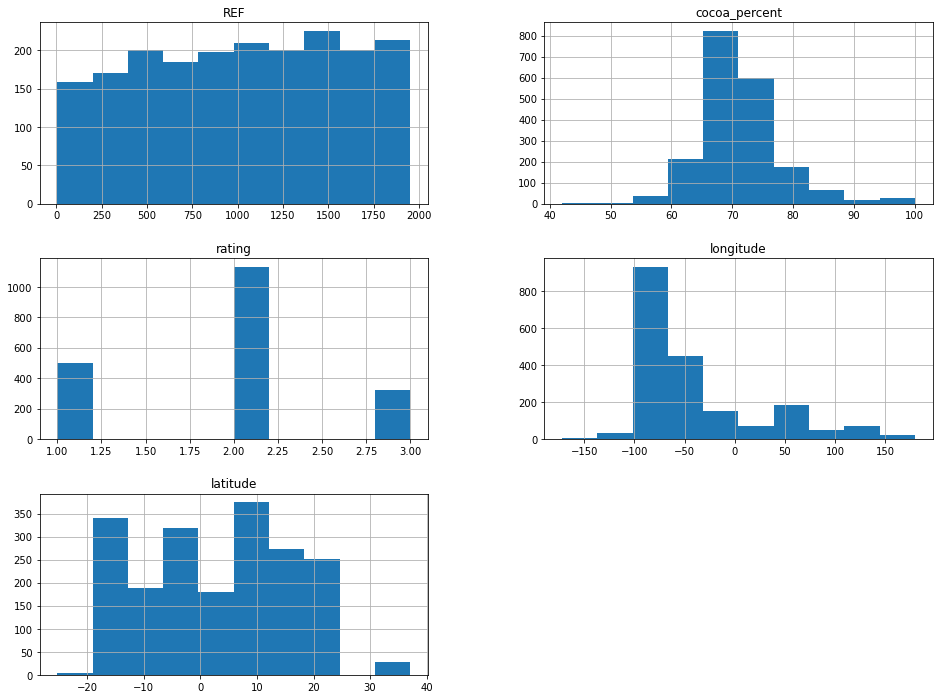

In [16]:
df_chocolate.hist(figsize=(16, 12));

## Neural Network!

In [17]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
df_chocolate= df_chocolate.drop(columns=["REF","bean_origin_or_bar_name","most_memorable_characteristics","latitude","longitude","company_location"], axis=1)
df_chocolate.head()

,company,review_date,cocoa_percent,rating,bean_type,broad_bean_origin_country,ingredients,continent,country_code
0,A. Morin,_2016_,63.0,3,missing,Sao Tome & Principe,"4- B,S,C,L",Africa,ST
1,A. Morin,_2015_,70.0,1,missing,Togo,"4- B,S,C,L",Africa,TG
2,A. Morin,_2015_,70.0,2,missing,Togo,"4- B,S,C,L",Africa,TG
3,A. Morin,_2015_,70.0,2,missing,Togo,"4- B,S,C,L",Africa,TG
4,A. Morin,_2015_,70.0,2,missing,Peru,"4- B,S,C,L",South America,PE


In [18]:
# Generate our categorical variable lists
chocolate_cat = df_chocolate.dtypes[df_chocolate.dtypes == 'object'].index.tolist()
chocolate_cat

['company',
 'review_date',
 'bean_type',
 'broad_bean_origin_country',
 'ingredients',
 'continent',
 'country_code']

In [19]:


# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(df_chocolate[chocolate_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(chocolate_cat)
encode_df.head()



,company_A. Morin,company_AMMA,company_Acalli,company_Adi,company_Aequare (Gianduja),company_Ah Cacao,company_Akesson's (Pralus),company_Alain Ducasse,company_Alexandre,company_Altus aka Cao Artisan,...,country_code_TT,country_code_TZ,country_code_UG,country_code_US,country_code_VE,country_code_VN,country_code_VU,country_code_WS,country_code_XX,country_code_ZZ
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Merge one-hot encoded features and drop the originals
df_chocolate = df_chocolate.merge(encode_df, left_index=True, right_index=True).drop(chocolate_cat, 1)
df_chocolate.head()

C:\Users\bjile\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,cocoa_percent,rating,company_A. Morin,company_AMMA,company_Acalli,company_Adi,company_Aequare (Gianduja),company_Ah Cacao,company_Akesson's (Pralus),company_Alain Ducasse,...,country_code_TT,country_code_TZ,country_code_UG,country_code_US,country_code_VE,country_code_VN,country_code_VU,country_code_WS,country_code_XX,country_code_ZZ
0,63.0,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,70.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,70.0,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,70.0,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,70.0,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Split our preprocessed data into our features and target arrays
y = df_chocolate["rating"]
X = df_chocolate.drop(["rating"],1) 

# Split the preprocessed data into a training and testing dataset
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

X_train, X_test, y_train, y_test = train_test_split(X,
   y,test_size= 0.4,train_size=0.6 , random_state=42, stratify=y)

C:\Users\bjile\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [23]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)


In [24]:
etc = ExtraTreesClassifier()
_ = etc.fit(X_resampled, y_resampled)
y_pred = etc.predict(X_test_scaled)

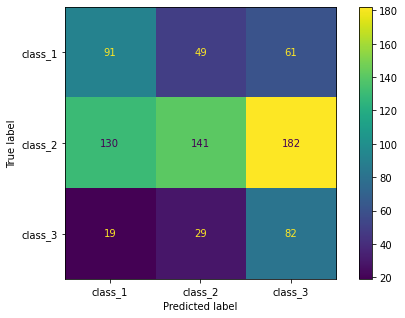

In [25]:
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=["class_1", "class_2", "class_3"],
)
cmp.plot(ax=ax)
plt.show();

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.38      0.45      0.41       201
           2       0.64      0.31      0.42       453
           3       0.25      0.63      0.36       130

    accuracy                           0.40       784
   macro avg       0.43      0.46      0.40       784
weighted avg       0.51      0.40      0.41       784



In [27]:
len(X_train_scaled[0])

575

# Random Forest

In [28]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_resampled, y_resampled)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")



 Random forest predictive accuracy: 0.407


In [29]:
# Calculated the balanced accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.40688775510204084

In [30]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 1", "Actual 2", "Actual 3"], columns=["Predicted 1", "Predicted 2","Predicted 3"])
cm_df

,Predicted 1,Predicted 2,Predicted 3
Actual 1,98,50,53
Actual 2,133,144,176
Actual 3,19,34,77


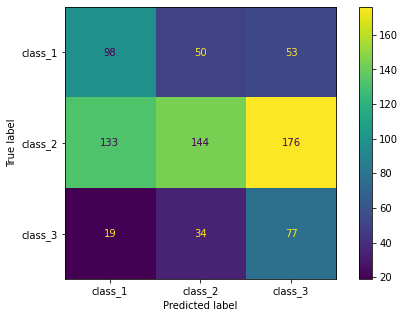

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=["class_1", "class_2", "class_3"],
)
cmp.plot(ax=ax)
plt.show();

In [32]:
# Print the imbalanced classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.39      0.49      0.43       201
           2       0.63      0.32      0.42       453
           3       0.25      0.59      0.35       130

    accuracy                           0.41       784
   macro avg       0.43      0.47      0.40       784
weighted avg       0.51      0.41      0.41       784



In [33]:
# Calculate feature importance in the Random Forest model.
importances = rf_model.feature_importances_



In [34]:
# We can sort the features by their importance.
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.09144085554397252, 'cocoa_percent'),
 (0.03988313843897576, 'company_Soma'),
 (0.028278155662417703, 'ingredients_3- B,S,C'),
 (0.02638937383530087, 'company_Vao Vao (Chocolaterie Robert)'),
 (0.02367645723250261, 'bean_type_Criollo'),
 (0.022664827964060764, 'bean_type_missing'),
 (0.020949462258701323, 'ingredients_Unknown'),
 (0.020416069465146243, 'country_code_VE'),
 (0.01918943821487446, 'ingredients_2- B,S'),
 (0.01885715756008944, 'review_date__2013_'),
 (0.018247343866004843, 'broad_bean_origin_country_Venezuela'),
 (0.017835332123369706, 'bean_type_Trinitario'),
 (0.017551864190582963, 'review_date__2015_'),
 (0.015921426508118286, 'review_date__2009_'),
 (0.014128256907935547, 'ingredients_4- B,S,C,V'),
 (0.01376491753173706, 'continent_South America'),
 (0.013601791972306857, 'broad_bean_origin_country_Peru'),
 (0.013539853503872339, 'review_date__2012_'),
 (0.013270453357288527, 'company_Hotel Chocolat (Coppeneur)'),
 (0.013268134068358164, 'country_code_PE'),
 (0.0130

# Support Vector Machine

In [35]:
# Create the SVM model
svm = SVC(kernel='rbf')

# Train the model
svm.fit(X_resampled, y_resampled)

# Evaluate the model
y_pred = svm.predict(X_test_scaled)
print(f" SVM model accuracy: {accuracy_score(y_test,y_pred):.3f}")

 SVM model accuracy: 0.358


In [36]:
# Calculated the balanced accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.35841836734693877

In [37]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 1", "Actual 2","Actual 3"], columns=["Predicted 1", "Predicted 2","Predicted 3"])
cm_df

,Predicted 1,Predicted 2,Predicted 3
Actual 1,138,19,44
Actual 2,253,65,135
Actual 3,46,6,78


In [38]:
# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.32      0.69      0.43       201
           2       0.72      0.14      0.24       453
           3       0.30      0.60      0.40       130

    accuracy                           0.36       784
   macro avg       0.45      0.48      0.36       784
weighted avg       0.55      0.36      0.32       784



# Deep Learning Model

In [39]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  256
hidden_nodes_layer2 = 128
hidden_nodes_layer3 = 64
hidden_nodes_layer4 = 32
hidden_nodes_layer5 = 16
hidden_nodes_layer6 = 8
hidden_nodes_layer7 = 4


nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer1, input_dim = number_input_features, activation = 'relu'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer2, activation = 'relu'))

# other hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer3, activation = 'relu'))
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer4, activation = 'relu'))
# nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer5, activation = 'relu'))
# nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer6, activation = 'relu'))
# nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer7, activation = 'relu'))


# Output layer
nn.add(tf.keras.layers.Dense(units = 3, activation = 'softmax'))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               147456    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 190,787
Trainable params: 190,787
Non-trainable params: 0
_________________________________________________________________


In [40]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [41]:
# Compile the model
nn.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics= ['accuracy'])

In [42]:
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch',
    period=5)

In [43]:
# Train the model
nn.fit(X_train_scaled, y_train, epochs = 100, callbacks=[cp_callback])

Epoch 1/100


ValueError: in user code:

    C:\Users\bjile\anaconda3\envs\mlenv\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\bjile\anaconda3\envs\mlenv\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\bjile\anaconda3\envs\mlenv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\bjile\anaconda3\envs\mlenv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\bjile\anaconda3\envs\mlenv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\bjile\anaconda3\envs\mlenv\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Users\bjile\anaconda3\envs\mlenv\lib\site-packages\tensorflow\python\keras\engine\training.py:797 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    C:\Users\bjile\anaconda3\envs\mlenv\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\bjile\anaconda3\envs\mlenv\lib\site-packages\tensorflow\python\keras\losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\bjile\anaconda3\envs\mlenv\lib\site-packages\tensorflow\python\keras\losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\bjile\anaconda3\envs\mlenv\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\bjile\anaconda3\envs\mlenv\lib\site-packages\tensorflow\python\keras\losses.py:1644 categorical_crossentropy
        y_true, y_pred, from_logits=from_logits)
    C:\Users\bjile\anaconda3\envs\mlenv\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\bjile\anaconda3\envs\mlenv\lib\site-packages\tensorflow\python\keras\backend.py:4862 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\bjile\anaconda3\envs\mlenv\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 3) are incompatible


In [ ]:


# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")



In [ ]:
nn.save("Chocolate_Ratings_ML_Multiclass.h5")